<a href="https://colab.research.google.com/github/Manu1ND/colab/blob/main/Paper_CamoNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Code to upload result to drive (to be deleted)

!pip install --upgrade gupload

usrname = "external"

     |████████████████████████████████| 56 kB 2.8 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.10
    Uninstalling google-api-python-client-1.12.10:
      Successfully uninstalled google-api-python-client-1.12.10
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.297 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.7.10 which is incompatible.


# Specs

In [2]:
  !nvidia-smi

Thu Feb 10 16:36:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=26ed0d0f11b63082984165664bd3b89dbc5291dac6a9335ff533cd6c6638fb67
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import dependencies

In [ ]:
!pip install fastai -q --upgrade
!pip install --upgrade albumentations
!pip install gdown
from fastai.vision.all import *
import gdown
import os
import pandas as pd

# Download Dataset

In [ ]:
gdown.download('https://drive.google.com/u/1/uc?id=1PsX8ULvWg-peKtUduyTqkyxfxXoom13S', './owl.zip', quiet=False)
!apt-get install zip unzip
!unzip ./owl.zip
!rm ./owl.zip

# Preprocessing

In [ ]:
seed = 1000

def seed_everything(seed = seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [ ]:
path = Path('./Dataset_OWL_COD10K_v3/')
train_images = path/'Train/Image'
train_labels = path/'Train/GT'
test_name = "Test"
test_images = path/test_name/'Image'
test_labels = path/test_name/'GT'

In [ ]:
def get_y_fn(x): 
  return Path(str(x).replace("Image","GT").replace(".jpg",".png"))

In [ ]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [ ]:
codes = ['background','owl']
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['owl']

In [ ]:
def foreground_acc(input, target):
    target = cast(target.squeeze(1), TensorBase)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
from albumentations import (
    Compose,
    Pixel,
    Blur,
    CLAHE,
    ChannelDropout,
    ChannelShuffle,
    ColorJitter,
    Downscale,
    Emboss,
    Equalize,
    FDA, #not used
    FancyPCA,
    FromFloat, #not used
    GaussNoise,
    GaussianBlur,
    GlassBlur,
    HistogramMatching, #not used
    HueSaturationValue,
    ISONoise,
    ImageCompression,
    InvertImg,
    MedianBlur,
    MotionBlur,
    MultiplicativeNoise,
    Posterize,
    RGBShift,
    RandomBrightnessContrast,
    RandomFog,
    RandomGamma,
    RandomRain,
    RandomShadow,
    RandomSnow,
    RandomSunFlare,
    RandomToneCurve,
    Sharpen,
    Solarize,
    Superpixels,
    ToFloat, #not used
    ToGray,
    ToSepia,

    # Spatial
    Affine,
    CenterCrop, #not used
    CoarseDropout,
    Crop, #not used
    CropAndPad, #not used
    CropNonEmptyMaskIfExists, #not used
    ElasticTransform,
    Flip,
    GridDistortion,
    GridDropout,
    HorizontalFlip,
    Lambda,
    LongestMaxSize,
    MaskDropout,
    NoOp,
    OpticalDistortion,
    PadIfNeeded,
    Perspective,
    PiecewiseAffine,
    RandomCrop, #not used
    RandomCropNearBBox, #not used
    RandomGridShuffle,
    RandomResizedCrop, #not used
    RandomRotate90,
    RandomScale,
    RandomSizedBBoxSafeCrop, #not used
    RandomSizedCrop, #not used
    Rotate,
    SafeRotate,
    ShiftScaleRotate,
    SmallestMaxSize,
    Transpose,
    VerticalFlip
)

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [ ]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        mask = np.array(mask)
        mask[mask==255]=1
        mask = PILMask.create(mask)
        return img, mask

# Compute Method

## Constant

In [ ]:
size = 224
bs = 6
splitter = RandomSplitter(valid_pct=0.2, seed=seed)
item_tfms = [Resize((size,size)), TargetMaskConvertTransform()]
batch_tfms = []
arch = resnet34
pretrained=True
metrics = [foreground_acc, Dice(), JaccardCoeff()]
act_cls = nn.ReLU
self_attention = False
lr = 1e-3
wd = None
epochs = 200

In [ ]:
monitor_training = "valid_loss"
comp_training = np.less

monitor_evaluating = "dice"
comp_evaluating = np.greater

patience = 50

In [ ]:
# Squish, Crop, Zero, Border
# 128x128, 256x256, 512x512

# Contrast, Flip, Brightness, Zoom

# Architecture: resnet18, resnet34, resnet50

# Metrics: Dice, JaccardCoeff

# Relu, Mish, None (swish)

# Patience: 25, 50, 100, 200

# epochs

In [ ]:
# Import csv or make new dataframe
if os.path.isfile("result.csv"):
  result_df = pd.read_csv("result.csv", header=[0,1], index_col=[0,1])
else:
  col_names = [('method_type',''), ('method_name',''), ('Training','valid_loss'),("Training",'foreground_acc'),("Training",'dice'),('Training','jaccard_coeff'),('Testing','valid_loss'),("Testing",'foreground_acc'),("Testing",'dice'),('Testing','jaccard_coeff')]
  col_list = pd.MultiIndex.from_tuples(col_names)
  result_df = pd.DataFrame(columns = col_list).set_index([('method_type'), ('method_name')])

result_df = result_df.sort_index(0)

## Compute Function

In [ ]:
def compute(method_name, method_type, size = size, splitter=splitter, item_tfms = item_tfms, batch_tfms = batch_tfms, bs = bs, arch = arch, pretrained = pretrained, metrics = metrics,
            act_cls = act_cls, self_attention = self_attention, lr = lr, wd = wd, epochs = epochs, patience = patience):
  
  if(len(batch_tfms)):
    transformPipeline = Compose(batch_tfms,p=1)
    transformPipeline = SegmentationAlbumentationsTransform(transformPipeline)
    item_tfms.append(transformPipeline)

  callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor = monitor_training, comp = comp_training, patience = patience),
    SaveModelCallback(monitor = monitor_training, comp = comp_training, every_epoch = False, fname = method_name)  
  ]
  
  dblock = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  splitter = splitter,
                  get_y = get_y_fn,
                  item_tfms = item_tfms,
                  batch_tfms = [Normalize.from_stats(*imagenet_stats)]
                  )
  
  dls = dblock.dataloaders(train_images, bs=bs, num_workers=0)

  seed_everything()

  learn = unet_learner(dls, arch, pretrained = pretrained, metrics = metrics, wd=wd,
                       act_cls = act_cls, self_attention = self_attention)

  if(lr):
    learn.fit_one_cycle(epochs, lr, cbs=callbacksFitBeforeUnfreeze)
  else:
    lr = learn.lr_find()
    print("~~~~~~~~~~~~~~~~~~~~~~~~~Learning Rate~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(lr[0].item())
    learn.fit_one_cycle(epochs, lr[0].item(), cbs=callbacksFitBeforeUnfreeze)

  # learn.load(method_name)
  # learn.unfreeze()
  # lr = learn.lr_find()
  # learn.fit_one_cycle(25, slice(lr[0].item()),cbs=callbacksFitBeforeUnfreeze)

  print("~~~~~~~~~~~~~~~~~~~~~~~~~Training Result~~~~~~~~~~~~~~~~~~~~~~~~~")
  train_validate = learn.validate()
  print(train_validate)

  test_img = get_image_files(test_images)
  dl = learn.dls.test_dl(test_img, with_labels=True)
  print("~~~~~~~~~~~~~~~~~~~~~~~~~Testing Result~~~~~~~~~~~~~~~~~~~~~~~~~~")
  test_validate = learn.validate(dl=dl)
  print(test_validate)
  
  result_df.loc[(method_type, method_name), :] = train_validate + test_validate
  #result_df.to_csv('result.csv')
  result_df.to_csv(f'{usrname}.csv')

  # Delete pth file
  !rm -rf ./models

  # Upload files to Drive (to be deleted)
  !gupload --to '1bP_PH9nhcoQSAh2bZC3T6FkggEYex90P' $"{usrname}".csv

  return learn

# Experiments

### 512x512

#### Crop

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.394934,0.347487,0.999948,0.000012,0.000006,01:13
1,0.335627,0.204072,0.975190,0.659931,0.492461,01:13
2,0.280567,0.177614,0.970299,0.768721,0.624328,01:13
3,0.228293,0.196532,0.946814,0.768007,0.623386,01:13
4,0.198657,0.227610,0.996639,0.683325,0.518978,01:13
5,0.174255,0.160224,0.980194,0.804593,0.673070,01:13
6,0.156431,0.242318,0.996911,0.646871,0.478056,01:13
7,0.139054,0.176861,0.968431,0.807670,0.677388,01:13
8,0.128658,0.169172,0.989210,0.790999,0.654259,01:13
9,0.116027,0.142105,0.976158,0.825016,0.702151,01:13


Better model found at epoch 0 with valid_loss value: 0.3474874198436737.


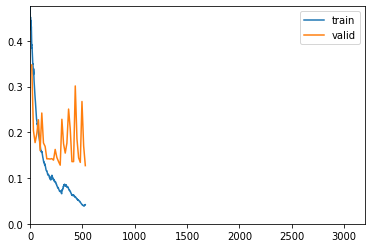

Better model found at epoch 1 with valid_loss value: 0.20407210290431976.
Better model found at epoch 2 with valid_loss value: 0.17761409282684326.
Better model found at epoch 5 with valid_loss value: 0.1602238267660141.
Better model found at epoch 9 with valid_loss value: 0.1421050876379013.
Better model found at epoch 11 with valid_loss value: 0.1416744589805603.
Better model found at epoch 13 with valid_loss value: 0.13924099504947662.
Better model found at epoch 16 with valid_loss value: 0.136229008436203.
Better model found at epoch 17 with valid_loss value: 0.1282355785369873.
Better model found at epoch 32 with valid_loss value: 0.12726546823978424.


RuntimeError: ignored

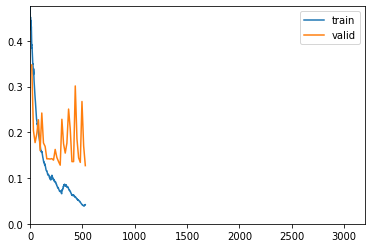

In [ ]:
compute("Crop", "Resize 512x512", item_tfms = [Resize((512,512), method=ResizeMethod.Crop), TargetMaskConvertTransform()])

#### Border

In [ ]:
compute("Border", "Resize 512x512", item_tfms = [Resize((512,512), method=ResizeMethod.Pad, pad_mode=PadMode.Border), TargetMaskConvertTransform()])

#### Reflection

In [ ]:
compute("Reflection", "Resize 512x512", item_tfms = [Resize((512,512), method=ResizeMethod.Pad, pad_mode=PadMode.Reflection), TargetMaskConvertTransform()])

#### Zero

In [ ]:
compute("Zero", "Resize 512x512", item_tfms = [Resize((512,512), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), TargetMaskConvertTransform()])

### Pixel


#### RandomShadow

In [ ]:
compute("RandomShadow", "Data Augmentation [Pixel]", batch_tfms=[RandomShadow()])

### 6

#### Pretrained True

##### DenseNet121

In [ ]:
compute("DenseNet121_Pretrained[True]", "Backbone [BS 6]", arch=densenet121, bs=6)

##### DenseNet161

In [ ]:
compute("DenseNet161_Pretrained[True]", "Backbone [BS 6]", arch=densenet161, bs=6)

##### DenseNet169

In [ ]:
compute("DenseNet169_Pretrained[True]", "Backbone [BS 6]", arch=densenet169, bs=6)

##### DenseNet201

In [ ]:
compute("DenseNet201_Pretrained[True]", "Backbone [BS 6]", arch=densenet201, bs=6)

##### ResNet50

In [ ]:
compute("ResNet50_Pretrained[True]", "Backbone [BS 6]", arch=resnet50, bs=6)

##### Resnet101

In [ ]:
compute("Resnet101_Pretrained[True]", "Backbone [BS 6]", arch=resnet101, bs=6)

##### Resnet152

In [ ]:
compute("Resnet152_Pretrained[True]", "Backbone [BS 6]", arch=resnet152, bs=6)

##### XResNet50

In [ ]:
compute("XResNet50_Pretrained[True]", "Backbone [BS 6]", arch=xresnet50, bs=6)

#### Pretrained False

##### AlexNet

In [ ]:
compute("AlexNet_Pretrained[False]", "Backbone [BS 6]", arch=alexnet, pretrained = False, bs=6)

##### DenseNet121

In [ ]:
compute("DenseNet121_Pretrained[False]", "Backbone [BS 6]", arch=densenet121, pretrained = False, bs=6)

##### DenseNet161

In [ ]:
compute("DenseNet161_Pretrained[False]", "Backbone [BS 6]", arch=densenet161, pretrained = False, bs=6)

##### DenseNet169

In [ ]:
compute("DenseNet169_Pretrained[False]", "Backbone [BS 6]", arch=densenet169, pretrained = False, bs=6)

##### DenseNet201

In [ ]:
compute("DenseNet201_Pretrained[False]", "Backbone [BS 6]", arch=densenet201, pretrained = False, bs=6)

##### ResNet50

In [ ]:
compute("ResNet50_Pretrained[False]", "Backbone [BS 6]", arch=resnet50, pretrained = False, bs=6)

##### ResNet101

In [ ]:
compute("ResNet101_Pretrained[False]", "Backbone [BS 6]", arch=resnet101, pretrained = False, bs=6)

##### ResNet152

In [ ]:
compute("ResNet152_Pretrained[False]", "Backbone [BS 6]", arch=resnet152, pretrained = False, bs=6)

##### SqueezeNet1_0

In [ ]:
compute("SqueezeNet1_0_Pretrained[False]", "Backbone [BS 6]", arch=squeezenet1_0, pretrained = False, bs=6)

##### SqueezeNet1_1

In [ ]:
compute("SqueezeNet1_1_Pretrained[False]", "Backbone [BS 6]", arch=squeezenet1_1, pretrained = False, bs=6)

##### vgg11_bn

In [ ]:
compute("vgg11_bn_Pretrained[False]", "Backbone [BS 6]", arch=vgg11_bn, pretrained = False, bs=6)

##### vgg13_bn

In [ ]:
compute("vgg13_bn_Pretrained[False]", "Backbone [BS 6]", arch=vgg13_bn, pretrained = False, bs=6)

##### vgg16_bn

In [ ]:
compute("vgg16_bn_Pretrained[False]", "Backbone [BS 6]", arch=vgg16_bn, pretrained = False, bs=6)

##### vgg19_bn

In [ ]:
compute("vgg19_bn_Pretrained[False]", "Backbone [BS 6]", arch=vgg19_bn, pretrained = False, bs=6)

##### XResNet18

In [ ]:
compute("XResNet18_Pretrained[False]", "Backbone [BS 6]", arch=xresnet18, pretrained = False, bs=6)

##### XResNet34

In [ ]:
compute("XResNet34_Pretrained[False]", "Backbone [BS 6]", arch=xresnet34, pretrained = False, bs=6)

##### XResNet50 - NA

In [ ]:
compute("XResNet50_Pretrained[False]", "Backbone [BS 6]", arch=xresnet50, pretrained = False, bs=6)

##### XResNet101

In [ ]:
compute("XResNet101_Pretrained[False]", "Backbone [BS 6]", arch=xresnet101, pretrained = False, bs=6)

##### XResNet152

In [ ]:
compute("XResNet152_Pretrained[False]", "Backbone [BS 6]", arch=xresnet152, pretrained = False, bs=6)